# #2 fMRS Spectrum Simulation

This file contains the protottyping and data exploration for setting up the monte carlo simulation.

It then generates the results and figures from the simulation results (generated using `run_full_mc.py`)

## Prototyping

First generate an FSL-MRS basis set from the ISMRM MRS study group challenge basis set.
Remove the TMS peak and the metabolte Ace.

In [1]:
%sx basis_tools convert basisset_JMRUI challenge_basis --remove_reference --hlsvd
%sx basis_tools conj challenge_basis challenge_basis
%sx rm challenge_basis/Ace.json

[]

View the generated basis

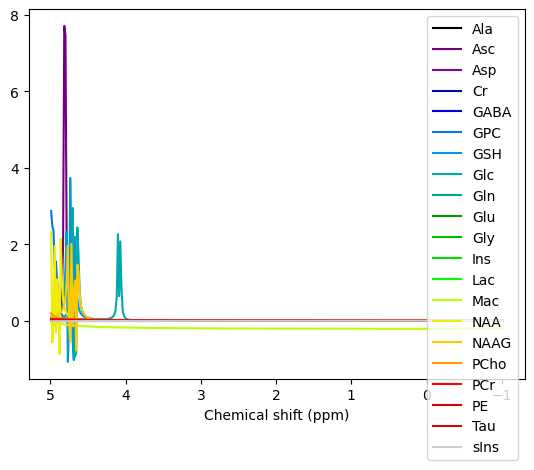

In [2]:
from fsl_mrs.utils import mrs_io
import fsl_mrs.utils.synthetic as synth
import matplotlib.pyplot as plt
import numpy as np
basis = mrs_io.read_basis('challenge_basis')
_ = basis.plot(ppmlim=(-1,5))

Define a function for generating a spectrum, and establish standard concentrations

In [3]:
def single_spectrum(concs_in, noise=200, lw=(14.0, 0.0)):
    synth_spec, mrs, _ = synth.syntheticFromBasisFile(
        'challenge_basis',
        points=1024,
        bandwidth=2000,
        broadening=lw,
        noisecovariance=[[noise]],
        concentrations=concs_in)
    mrs.FID = synth_spec
    return mrs

concs = synth.synthetic_from_basis.standardConcentrations(basis.names)
original_concs = {key: conc for key, conc in zip(basis.names, concs)}
original_concs['Mac'] = 5.0
original_concs

Mac not in standard concentrations. Setting to random between 1 and 5.


{'Ala': 0.6,
 'Asc': 1.2,
 'Asp': 2.4,
 'Cr': 4.87,
 'GABA': 1.2,
 'GPC': 0.74,
 'GSH': 1.2,
 'Glc': 1.2,
 'Gln': 3.37,
 'Glu': 12.41,
 'Gly': 1.2,
 'Ins': 7.72,
 'Lac': 0.6,
 'Mac': 5.0,
 'NAA': 13.8,
 'NAAG': 1.2,
 'PCho': 0.85,
 'PCr': 4.87,
 'PE': 1.8,
 'Tau': 1.8,
 'sIns': 0.3}

Explore SNR and linewidth options

Narrow:
33.804762299319975
5.868321230632162
Wide:
23.669917372301036
9.559582342869854


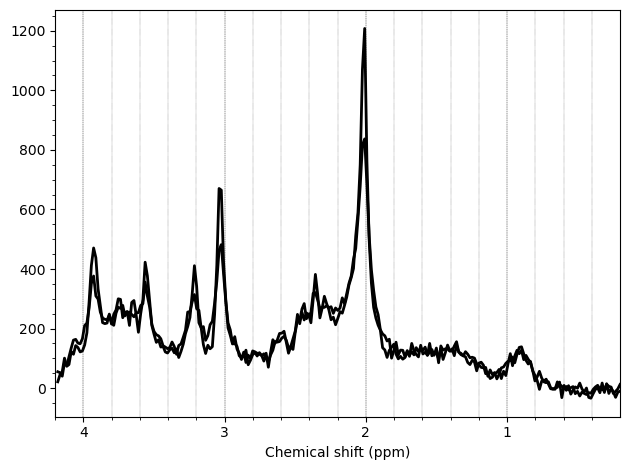

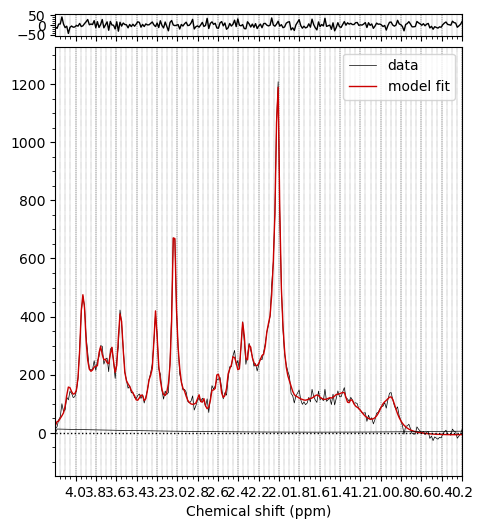

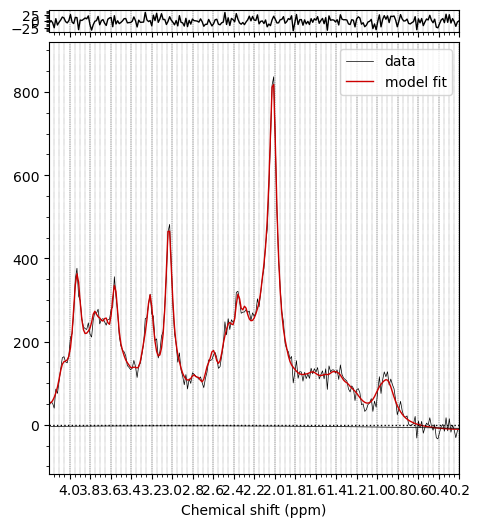

In [4]:
mrs_narrow = single_spectrum(original_concs,  lw=(11.0, 0.0))
mrs_wide = single_spectrum(original_concs,  lw=(23.0, 0.0))
mrs_narrow.plot()
mrs_wide.plot()

res_narrow = mrs_narrow.fit()
fit_fig = res_narrow.plot(mrs_narrow)
fit_fig.set_size_inches(9/2, 10/2)

res_wide = mrs_wide.fit()
fit_fig = res_wide.plot(mrs_wide)
fit_fig.set_size_inches(9/2, 10/2)

print('Narrow:')
SNR, FWHM = res_narrow.getQCParams()
print(SNR['SNR_NAA'])
print(FWHM['fwhm_NAA'])

print('Wide:')
SNR, FWHM = res_wide.getQCParams()
print(SNR['SNR_NAA'])
print(FWHM['fwhm_NAA'])


### Create temporal model

Matches previous section model

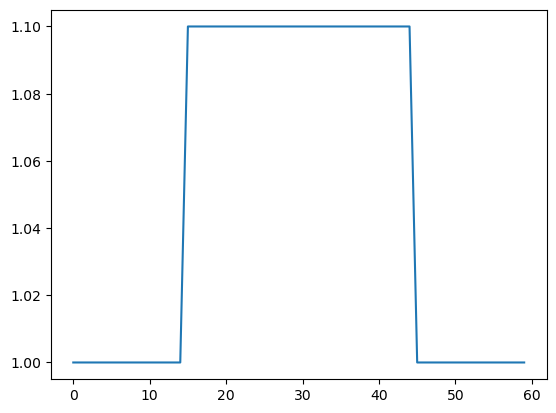

In [5]:
tr = 2
ta = 120
stim_duration = 60
stim_start = 30

nt = int(ta / tr)
stim_steps = int(stim_duration / tr)
stim_start_step = int(stim_start / tr)

def boxcar(delta):
    response = np.ones(nt)
    response[stim_start_step:(stim_start_step+stim_steps)] += delta
    return response

plt.plot(boxcar(0.1))
plt.show()

Create function to generate a time series of spectra with one metabolite varying in concentration according to above model

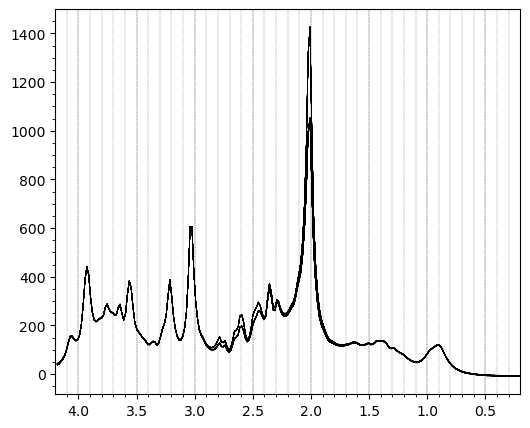

In [6]:
def gen_timeseries(metabolite, delta, base_concs, **kwargs):
    mrs_list = []
    design = boxcar(delta)
    concs_in = base_concs.copy()
    for factor in design:
        concs_in[metabolite] = base_concs[metabolite] * factor
        mrs_list.append(single_spectrum(concs_in, **kwargs))
    return mrs_list

naa_list = gen_timeseries('NAA', 0.5, original_concs, noise=1)

from fsl_mrs.utils.plotting import plot_spectra
list_fig = plot_spectra(naa_list, plot_avg=False, ppmlim=(0.2, 4.2))
list_fig.set_size_inches(6, 5)

### Prtoptype a singe monte-carlo simulation repetition

In [7]:
from fsl_mrs import dynamic as dyn
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix

Fitargs = {
    'baseline_order': 0,
    'ppmlim': (0.2, 4.2),
    'model': 'lorentzian'}

frame_times = np.arange(60) * tr
conditions = ['STIM', ]
duration = [stim_duration, ]
onsets = [stim_start, ]  # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions,
                       'onset': onsets,
                       'duration': duration})

design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=0,
    hrf_model='fir'
)


def one_rep(metabolite, delta, base_concs, noise):
    obj = dyn.dynMRS(
        gen_timeseries(metabolite, delta, base_concs, noise=noise),
        design_matrix.to_numpy(),
        'dyn_model.py',
        rescale=False,
        **Fitargs)

    init = obj.initialise(verbose=False)
    dyn_fit = obj.fit(init=init)
    return dyn_fit.init_free_dataframe, dyn_fit.mean_free

Test for high SNR condition: NAA + low noise

Should accurately fit a delta of 0.2 using both methods

In [8]:
init_test, dyn_test = one_rep('NAA', 0.2, original_concs, noise=10)

print('Dynamic:')
print(dyn_test.conc_NAA_beta0/dyn_test.conc_NAA_beta1)
print('Independent:')
print(init_test.conc_NAA_beta0/init_test.conc_NAA_beta1)

Dynamic:
0.20076790291289381
Independent:
0.19973902402326843


## Results and figure generation for #2 fmrs spectrum simulation

Load the results tables generated using `run_full_mc.py`

In [9]:
from pathlib import Path
import re
import pandas as pd
name_parts = re.compile(r'(\w+)_(\w+)_(\d+\.\d)_(\d+\.\d)_(\d\.\d)')
sim_res = Path('sim_results')
type = []
metab = []
nv = []
delta = []
lw = []
all_df = []
for fp in sim_res.glob('*.csv'):
    type.append(name_parts.search(fp.stem)[1])
    metab.append(name_parts.search(fp.stem)[2])
    nv.append(float(name_parts.search(fp.stem)[3]))
    lw.append(float(name_parts.search(fp.stem)[4]))
    delta.append(float(name_parts.search(fp.stem)[5]))
    all_df.append(pd.read_csv(fp, index_col=0))

mi = pd.MultiIndex.from_arrays([type, metab, nv, lw])
full_sim_data = pd.concat(all_df, keys=mi)
full_sim_data.shape

(42000, 48)

Look at the mean fMRS delta.

Select the beta0 and beta1 term (delta and baseline concentration) for the metabolite changing

In [10]:
mean_df = full_sim_data.groupby(level=[0,1,3]).mean()

mean_df_b0 = mean_df.filter(regex='conc_.*_beta0', axis=1)
mean_df_b0.columns = mean_df_b0.columns.str.replace('conc_','')
mean_df_b0.columns = mean_df_b0.columns.str.replace('_beta0','')
mean_df_b1 = mean_df.filter(regex='conc_.*_beta1', axis=1)
mean_df_b1.columns = mean_df_b1.columns.str.replace('conc_','')
mean_df_b1.columns = mean_df_b1.columns.str.replace('_beta1','')

mean_deltas = []
for metab in mean_df_b1.columns:
    mean_deltas.append((mean_df_b0/mean_df_b1).loc[pd.IndexSlice[:,metab,:], metab].unstack(level=1))
mean_deltas = pd.concat(mean_deltas,axis=1).T
mean_deltas

dynamic                init          
          11.0      23.0      11.0      23.0
Ala   0.205741  0.210994  0.204398  0.204372
Asc   0.196618  0.199124  0.194743  0.188533
Asp   0.198640  0.207571  0.197178  0.202344
Cr    0.199885  0.203096  0.199904  0.204336
GABA  0.201823  0.193427  0.201586  0.175359
GPC   0.195646  0.197743  0.196863  0.196704
GSH   0.198008  0.200357  0.197495  0.203856
Glc   0.200099  0.195019  0.200346  0.193999
Gln   0.200807  0.206421  0.200658  0.204370
Glu   0.200422  0.200570  0.200566  0.200969
Gly   0.193308  0.198694  0.193790  0.193886
Ins   0.200325  0.200383  0.200482  0.201181
Lac   0.197886  0.198132  0.199076  0.195851
Mac   0.199915  0.200272  0.200057  0.200860
NAA   0.199839  0.199813  0.199807  0.199847
NAAG  0.198960  0.195137  0.198870  0.193840
PCho  0.201141  0.207225  0.201292  0.207549
PCr   0.199975  0.199284  0.199610  0.199585
PE    0.200296  0.193513  0.201384  0.192897
Tau   0.200974  0.204852  0.202450  0.204700
sIns  0.200462  0.195957  0.200965  0.195158

Look at the ratio of uncertainties (std) for the beta0 and beta1 (delta and baseline concentrations) parameters for the metabolites that are changing.

In [11]:
ratio = full_sim_data.groupby(level=[0,1,3]).std().loc['init']\
    / full_sim_data.groupby(level=[0,1,3]).std().loc['dynamic']

ratios_beta0 = ratio.filter(regex='conc_.*_beta0', axis=1)
ratios_beta0.columns = ratios_beta0.columns.str.replace('conc_','')
ratios_beta0.columns = ratios_beta0.columns.str.replace('_beta0','')

ratios_beta1 = ratio.filter(regex='conc_.*_beta1', axis=1)
ratios_beta1.columns = ratios_beta1.columns.str.replace('conc_','')
ratios_beta1.columns = ratios_beta1.columns.str.replace('_beta1','')

ratios_beta0.groupby(level=[1]).mean().T
ratios_beta1.groupby(level=[1]).mean().T

11.0      23.0
Ala   1.002001  0.982361
Asc   1.030136  0.995031
Asp   1.076863  1.120351
Cr    1.097611  1.109238
GABA  1.012005  0.973590
GPC   1.025133  1.023300
GSH   1.039274  1.025162
Glc   1.005668  1.000634
Gln   1.034645  1.021609
Glu   1.021410  0.997484
Gly   1.018905  1.002461
Ins   1.032685  1.011354
Lac   1.007125  0.990615
Mac   1.177499  1.158468
NAA   1.208035  1.221537
NAAG  1.122476  1.139383
PCho  1.032040  1.020319
PCr   1.083768  1.096512
PE    1.089019  1.091995
Tau   1.058277  1.056658
sIns  1.004866  0.998217

Calculate the parameter correlations for concentrations in independent spectra.

Do this for both linewidths tested.

Take mean across 50 fits.

In [12]:
# Calculate mean corr matrix from small sample
corr_mat_store = []
for idx in range(50):
    corr_mat_store.append(single_spectrum(original_concs, lw=(11,0)).fit().corr)
mean_corr_mat_11 = np.mean(corr_mat_store, axis=0)

corr_mat_store = []
for idx in range(50):
    corr_mat_store.append(single_spectrum(original_concs, lw=(23,0)).fit().corr)
mean_corr_mat_23 = np.mean(corr_mat_store, axis=0)

Calculate the mean correlation of concentrations with other concentrations (basis scaling amplitudes) and all parameters.

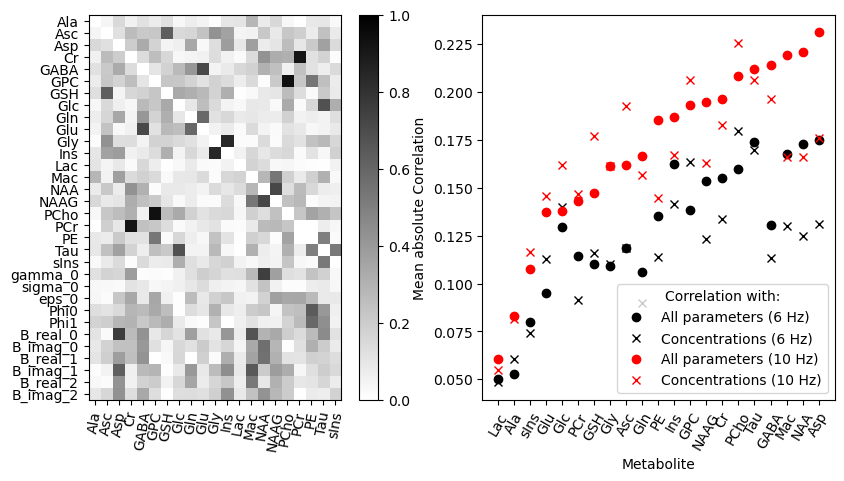

In [13]:
om_len = len(res_narrow.original_metabs)
mean_corr_mat_11_diag = mean_corr_mat_11 - np.diag(np.diag(mean_corr_mat_11))
mean_corr_mat_23_diag = mean_corr_mat_23 - np.diag(np.diag(mean_corr_mat_23))

metab_corr_11 = mean_corr_mat_11_diag[:om_len, :om_len]
metab_corr_23 = mean_corr_mat_23_diag[:om_len, :om_len]

mean_corr_metab_11 = np.mean(np.abs(metab_corr_11),axis=0)
mean_corr_11 = np.mean(np.abs(mean_corr_mat_11_diag),axis=0)[:om_len]

mean_corr_metab_23 = np.mean(np.abs(metab_corr_23),axis=0)
mean_corr_23 = np.mean(np.abs(mean_corr_mat_23_diag),axis=0)[:om_len]

sortindx = np.argsort(mean_corr_23)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


cax = axes[0].matshow(np.abs(mean_corr_mat_23_diag)[:, :21], cmap=plt.cm.binary, vmin=0, vmax=1)
axes[0].set_yticks(ticks=np.arange(mean_corr_mat_23_diag.shape[0]))
axes[0].set_yticklabels(res_narrow.params_names)
axes[0].set_xticks(ticks=np.arange(21))
axes[0].set_xticklabels(res_narrow.params_names[:21], rotation=80)
axes[0].tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
fig.colorbar(cax)

axes[1].plot(mean_corr_11[sortindx], 'ok', label='All parameters (6 Hz)')
axes[1].plot(mean_corr_metab_11[sortindx], 'xk', label='Concentrations (6 Hz)')
axes[1].plot(mean_corr_23[sortindx], 'or', label='All parameters (10 Hz)')
axes[1].plot(mean_corr_metab_23[sortindx], 'xr', label='Concentrations (10 Hz)')
axes[1].set_xticks(np.arange(len(res_narrow.original_metabs)))
axes[1].set_xticklabels(
    np.asarray(res_narrow.original_metabs)[sortindx],
    rotation = 60)
axes[1].set_xlabel('Metabolite')
axes[1].set_ylabel('Mean absolute Correlation')
axes[1].legend(title='Correlation with:')
# plt.show()
plt.savefig('../../publication/figures/s4_spectrum_correlations.png', dpi=400, bbox_inches='tight', transparent=True)

In [132]:
naa_example_narrow = gen_timeseries('NAA', 0.2, original_concs, noise=200, lw=(11.0, 0.0))
naa_example_wide = gen_timeseries('NAA', 0.2, original_concs, noise=200, lw=(23.0, 0.0))

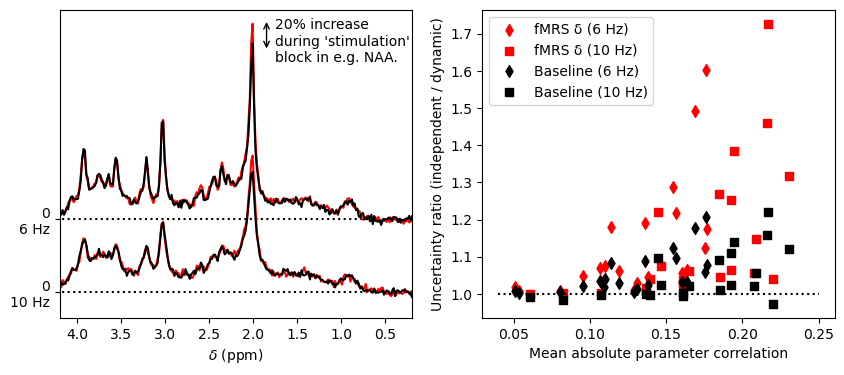

In [226]:
ratios_beta0_11 = ratios_beta0.groupby(level=[1]).mean().loc[11.0,:]
ratios_beta0_23 = ratios_beta0.groupby(level=[1]).mean().loc[23.0,:]
ratios_beta1_11 = ratios_beta1.groupby(level=[1]).mean().loc[11.0,:]
ratios_beta1_23 = ratios_beta1.groupby(level=[1]).mean().loc[23.0,:]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ppm_axis = naa_example_narrow[0].getAxes()
base_narrow = naa_example_narrow[0].get_spec().real
stim_narrow = naa_example_narrow[30].get_spec().real
axes[0].plot(ppm_axis, 500 + stim_narrow, 'r')
axes[0].plot(ppm_axis, 500 + base_narrow, 'k')

base_wide = naa_example_wide[0].get_spec().real
stim_wide = naa_example_wide[30].get_spec().real
axes[0].plot(ppm_axis, stim_wide, 'r')
axes[0].plot(ppm_axis, base_wide, 'k')
axes[0].hlines([0, 500], 0.2,4.2, linestyles=':', colors='k')
axes[0].set_xlim([4.2, 0.2])
axes[0].set_yticks([0, 500])
axes[0].set_yticklabels(['0\n10 Hz', '0\n6 Hz'])
axes[0].set_xlabel('$\delta$ (ppm)')

axes[0].annotate("",
            xy=(1.85, 1650), xycoords='data',
            xytext=(1.85, 1870), textcoords='data',
            arrowprops=dict(
                arrowstyle="<->"),)
axes[0].text(1.75, 1580, "20% increase \nduring 'stimulation'\nblock in e.g. NAA.")

axes[1].scatter(mean_corr_11, ratios_beta0_11.to_numpy(), c='r', marker='d', label='fMRS δ (6 Hz)')
axes[1].scatter(mean_corr_23, ratios_beta0_23.to_numpy(), c='r', marker='s', label='fMRS δ (10 Hz)')
axes[1].scatter(mean_corr_11, ratios_beta1_11.to_numpy(), c='k', marker='d', label='Baseline (6 Hz)')
axes[1].scatter(mean_corr_23, ratios_beta1_23.to_numpy(), c='k', marker='s', label='Baseline (10 Hz)')
axes[1].hlines(1.0, xmin=0.04, xmax=0.25, linestyles=':', colors='k')
axes[1].set_ylabel('Uncertainty ratio (independent / dynamic)')
axes[1].set_xlabel('Mean absolute parameter correlation')
axes[1].set_xticks(np.linspace(0.05, 0.25,5))
axes[1].legend()
plt.savefig('../../publication/figures/fig2cd_spectrum_ratios.png', dpi=400, bbox_inches='tight', transparent=True)
